In [1]:
import os
import sys
#sys.path.insert(0, os.path.dirname(os.getcwd()))
import pickle

import numpy as np
import torch
#import torch.cuda
import timeit
import pandas as pd
#import argparse
import itertools
from load_data import load_data # segment_SHAP
from evaluation.metrics.segmentstats import SegmentStats_metric
from models.predictor_utils import load_predictor
from pickle import dump



In [2]:
# PATHS
datasets_folder_path = None
attributions_folder_path = None
trained_models_folder_path = None
save_results_folder_path = None

In [3]:
demo_mode = False

In [4]:
# settings
dataset_names = ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"]    #[sys.argv[1]] # ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"]
segmentation_names = ["clasp","greedygaussian", "equal", "infogain","nnsegment"] # ["clasp","greedygaussian", "equal", "infogain","nnsegment"] 


metric_name = "segmentstats"
results_prefix = "segmentstats" #"evaluation"


demo_mode_samples = 25
# demo
if demo_mode:
    dataset_names = ['UWAVE']
    predictor_names = ['resNet'] #['randomForest', 'resNet', 'miniRocket']
    segmentation_names = ['nnsegment']
    background_names = ["average"]#, 'zero','sampling']
    normalization_names = ["default", "normalized"]

# optional
# # get infos about which explanations are evaluated
# datasets = list( explanations['attributions'].keys() )
# segmentations = list( explanations['attributions'][datasets[0]].keys() )
# predictors = list( explanations['attributions'][datasets[0]][segmentations[0]].keys() )
# backgrounds = list( explanations['attributions'][datasets[0]][segmentations[0]][predictors[0]].keys() )
# result_types = ['default','normalized']

cwd = os.getcwd()
if datasets_folder_path is None:
    datasets_folder_path = "datasets" #os.path.join(cwd, "datasets")
if attributions_folder_path is None:
    attributions_folder_path = "attributions"
if trained_models_folder_path is None:
    trained_models_folder_path = "trained_models"
if save_results_folder_path is None:
    save_results_folder_path = os.path.join("evaluation", "results", "segmentstats_results")


default_results = (('entropy_mean', 0),
                    ('entropy_std', 0),
                    ('n_segments_mean', 0.0),
                    ('n_segments_std', 0.0),)

In [5]:
# column_names = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric', 'Perturb', "Result"]
# df = pd.DataFrame(data=data_list, columns = column_names)

In [6]:
# df

In [7]:


# device
device = "cuda" if torch.cuda.is_available() else "cpu"

#starttime = timeit.default_timer()

eval_metric = SegmentStats_metric()

for dataset_name in dataset_names:
    print("Dataset: ", dataset_name)
    # loading dataset
    X_train, X_test, y_train, y_test, enc = load_data(subset='all', dataset_name=dataset_name, path=datasets_folder_path)
    if demo_mode:
        X_test, y_test = X_test[:demo_mode_samples], y_test[:demo_mode_samples]

    eval_metric.fit_data(X_train, X_test, y_train, y_test)


    filenames = np.array(os.listdir(attributions_folder_path))
    filenames_relevant_to_dataset = filenames[np.array([dataset_name in filename for filename in filenames])]
    # filenames_exp_format = filenames_relevant_to_dataset[np.array(["all_results" in filename for filename in filenames_relevant_to_dataset])]
    # filenames_seg_format = filenames_relevant_to_dataset[np.array(["segmentations" in filename for filename in filenames_relevant_to_dataset])]

    data_list = []

    for attribution_filename in filenames_relevant_to_dataset:

        explanations = np.load(os.path.join(attributions_folder_path, attribution_filename), allow_pickle=True).item() # FileNotFoundError
        segmentation_names = np.array(list(explanations["segments"][dataset_name].keys()))
        # label_mapping = explanations['label_mapping'][dataset_name]

        for segmentation_name in segmentation_names:

            print("\tassessing", segmentation_name)

            # load model and explanations to access
            segments = explanations['segments'][dataset_name][segmentation_name]

            try:

                results = eval_metric.evaluate(segments)
            
            except Exception as e:
                print("\terror found, using default value")
                print("\t", e) 
                results = default_results

            for result_tuple in results:
                data_list.append((dataset_name, segmentation_name, metric_name) + result_tuple)

            #print("elapsed time", (timeit.default_timer() - starttime))


        # save
        column_names = ['Dataset', 'Segmentation', 'Metric', 'Perturb', "Result"]
        df = pd.DataFrame(data=data_list, columns = column_names)
        file_name = "_".join((results_prefix, dataset_name))
        result_path = os.path.join(save_results_folder_path, file_name)
        if not demo_mode:
            df.to_csv(result_path)


Dataset:  UWAVE


	assessing binSeg
	assessing bottomUp
	assessing kernelCPD
	assessing windowBased
	assessing clasp
	assessing equal
	assessing greedygaussian
	assessing infogain
	assessing nnsegment
	assessing bottomUp
	assessing binSeg
	assessing kernelCPD
	assessing windowBased
	assessing equal
	assessing clasp
	assessing greedygaussian
	assessing infogain
	assessing nnsegment
	assessing bottomUp
	assessing binSeg
	assessing kernelCPD
	assessing windowBased
	assessing equal
	assessing clasp
	assessing greedygaussian
	assessing infogain
	assessing nnsegment
	assessing binSeg
	assessing windowBased
	assessing bottomUp
	assessing kernelCPD
	assessing equal
	assessing clasp
	assessing greedygaussian
	assessing infogain
	assessing nnsegment
Dataset:  KeplerLightCurves
	assessing bottomUp
	assessing binSeg
	assessing kernelCPD
	assessing windowBased
	assessing equal
	assessing clasp
	assessing greedygaussian
	assessing infogain
	assessing nnsegment
	assessing binSeg
	assessing kernelCPD
	assessing bottomU

In [8]:
df.head()

,Dataset,Segmentation,Metric,Perturb,Result
0,EOG,binSeg,segmentstats,entropy_mean,0.797561
1,EOG,binSeg,segmentstats,entropy_std,0.115816
2,EOG,binSeg,segmentstats,n_segments_mean,5.000000
3,EOG,binSeg,segmentstats,n_segments_std,0.000000
4,EOG,bottomUp,segmentstats,entropy_mean,0.800438


In [9]:
# 0/0

In [10]:
save_results_folder_path

'evaluation\\results\\segmentstats_results'

In [11]:
path = os.path.join(save_results_folder_path)
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df = merged_df
df

,Dataset,Segmentation,Metric,Perturb,Result
0,EOG,binSeg,segmentstats,entropy_mean,0.797561
1,EOG,binSeg,segmentstats,entropy_std,0.115816
2,EOG,binSeg,segmentstats,n_segments_mean,5.000000
3,EOG,binSeg,segmentstats,n_segments_std,0.000000
4,EOG,bottomUp,segmentstats,entropy_mean,0.800438
...,...,...,...,...,...
139,UWAVE,infogain,segmentstats,n_segments_std,0.000000
140,UWAVE,nnsegment,segmentstats,entropy_mean,0.973800
141,UWAVE,nnsegment,segmentstats,entropy_std,0.011122
142,UWAVE,nnsegment,segmentstats,n_segments_mean,6.443925


In [12]:
import matplotlib.pyplot as plt

Entropy

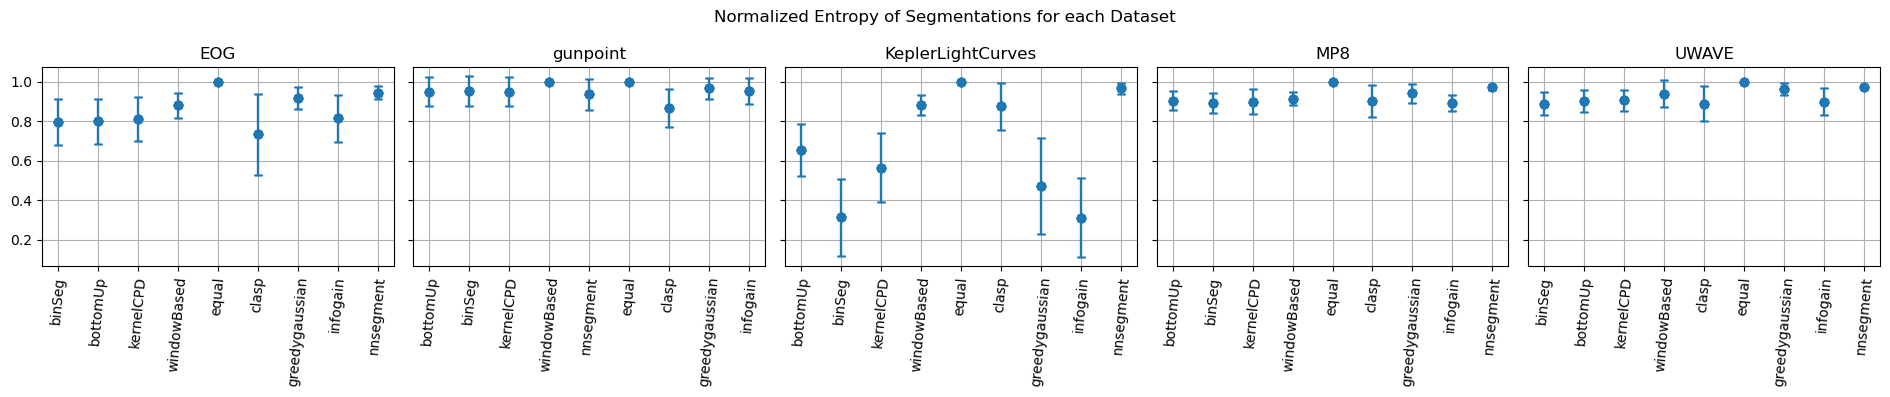

In [13]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="segmentstats")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (19,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="entropy_mean")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = df4["Result"].values

    mask = (df3["Perturb"]=="entropy_std")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    e = df5["Result"].values

    ax[i].errorbar(x, y, e, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=85)

fig.suptitle("Normalized Entropy of Segmentations for each Dataset")
fig.tight_layout()

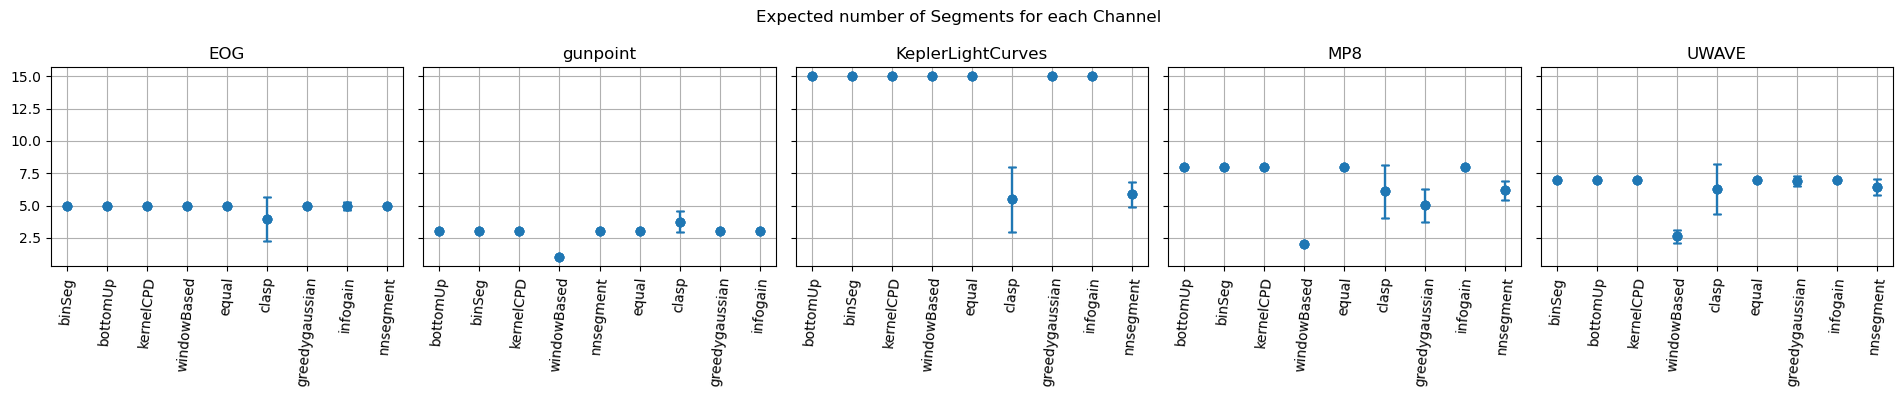

In [14]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="segmentstats")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (19,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="n_segments_mean")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = df4["Result"].values

    mask = (df3["Perturb"]=="n_segments_std")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    e = df5["Result"].values

    ax[i].errorbar(x, y, e, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=85)

fig.suptitle("Expected number of Segments for each Channel")
fig.tight_layout()